# InfoGAN
### Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets

#### 작성자: 고려대학교 수학과 석사과정 최선묵

[References]  
[Paper Link](https://arxiv.org/abs/1606.03657)  
[Code Link](https://towardsdatascience.com/build-infogan-from-scratch-f20ee85cba03)


## Preparation

In [ ]:
!pip install tensorflow==2.4.0
!pip install tensorflow-probability==0.12.2

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import ReLU, LeakyReLU, Reshape
from tensorflow.keras.layers import BatchNormalization, Concatenate, Flatten

from tensorflow.keras.models import Model

from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

from tensorflow.keras.optimizers import Adam

### Hyperparameters for latent codes

In [3]:
# Noise
noise_dim = 62

# Categorical codes
num_cat = 10

# Continuous codes
num_conti = 2

latent_input_size = noise_dim + num_cat + num_conti

## Generator

In [4]:
def create_generator_continuous(n_filters=128, input_size=latent_input_size):
    # Build functional API model
    # input
    input_tensor = Input(shape=(input_size, ))

    # Fully-connected layer.
    x = Dense(units=1024, use_bias=False, kernel_initializer='he_uniform') (input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Fully-connected layer. The output should be able to reshape into 7x7
    x = Dense(units=7*7*128, use_bias=False, kernel_initializer='he_uniform') (x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Reshape
    x = Reshape(target_shape=(7, 7, 128))(x)

    nf = n_filters
    # First transposed convolutional layer

    x = Conv2DTranspose(nf, kernel_size=(4, 4), strides=(2, 2), padding='same', 
                        use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Number of filters halved after each transposed convolutional layer
    nf = nf//2
    
    # Second transposed convolutional layer
    # strides=(2, 2): shape is doubled after the transposed convolution
    x = Conv2DTranspose(nf, kernel_size=(4, 4), strides=(2, 2), padding='same', 
                        use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Final transposed convolutional layer: output shape: 28x28x1, tanh activation
    output = Conv2DTranspose(1, kernel_size=(4, 4), strides=(1, 1), padding="same", 
                             activation="tanh", kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    return model

In [5]:
g_model = create_generator_continuous()

In [6]:
g_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 74)]              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              75776     
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              6422528   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 6272)              0     

## Discriminator

In [7]:
def create_discriminator_continuous(n_filters=64, n_class=num_cat, n_conti=num_conti, input_shape=(28, 28, 1)):
    # Build functional API model
    # Image Input
    image_input = Input(shape=input_shape)

    nf = n_filters
    
    x = Conv2D(nf, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=True)(image_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Number of filters doubled after each convolutional layer
    nf = nf*2
    
    # Second convolutional layer
    # Output shape: 7x7
    x = Conv2D(nf, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Flatten the convolutional layers
    x = Flatten()(x)

    # FC layer
    x = Dense(1024, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    # Discriminator output. Sigmoid activation function to classify "True" or "False"
    d_output = Dense(1, activation='sigmoid')(x)

    # Auxiliary output. 
    q = Dense(128, use_bias=False)(x)
    q = BatchNormalization()(q)
    q = LeakyReLU(alpha=0.1)(q)

    # Classification (discrete output)
    q_cat = Dense(n_class, activation="softmax")(q)

    # Gaussian distribution mean (continuous output)
    mu = Dense(n_conti)(q)

    # Gaussian distribution standard deviation (exponential activation to ensure the value is positive)
    sigma = Dense(n_conti, activation=lambda x: tf.math.exp(x))(q)

    # Discriminator model (not compiled)
    d_model = Model(inputs=image_input, outputs=d_output)

    # Auxiliary model (not compiled)
    q_model = Model(inputs=image_input, outputs=[q_cat, mu, sigma])
    
    return d_model, q_model

In [8]:
d_model, q_model = create_discriminator_continuous()

In [9]:
d_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1088      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         131072    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0   

In [10]:
q_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   1088        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 14, 64)   0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [26]:
class InfoGAN_Continuous(tf.keras.Model):
    def __init__(self, d_model, g_model, q_model, noise_size=noise_dim, num_classes=num_cat, n_conti=num_conti, seed=None):
        super(InfoGAN_Continuous, self).__init__()
        self.d_model = d_model
        self.g_model = g_model
        self.q_model = q_model
        self.noise_size = noise_size
        self.num_classes = num_classes
        self.n_conti = n_conti
        self.seed = seed

    def compile(self, d_optimizer, g_optimizer, q_optimizer):
        super(InfoGAN_Continuous, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.q_optimizer = q_optimizer

    def create_gen_input(self, batch_size, seed):
        
        # create noise input
        noise = tf.random.normal([batch_size, self.noise_size], seed=seed)
        
        # Create categorical latent code
        cat_code = tf.random.uniform([batch_size], minval=0, maxval=self.num_classes, dtype=tf.int32, seed=seed)
        cat_code = tf.one_hot(cat_code, depth=self.num_classes)
        
        # Create two continuous latent codes
        conti_code = tf.random.uniform([batch_size, self.n_conti], minval=-1, maxval=1, seed=seed)
        
        return cat_code, conti_code, noise

    def concat_inputs(self, input_tensor):
        concat_input = Concatenate()(input_tensor)
        return concat_input

    def train_step(self, real_image_batch):
        
        # Define loss functions
        binary_loss = BinaryCrossentropy()
        categorical_loss = CategoricalCrossentropy()
        
        # Half-batch for training discriminator and batch for training generator and auxiliary model
        batch_size = tf.shape(real_image_batch)[0]
        
        # Create generator input 
        g_cat, g_conti, g_noise = self.create_gen_input(batch_size=batch_size, seed=self.seed)
        g_input = self.concat_inputs([g_cat, g_conti, g_noise])
        
        with tf.GradientTape() as d_tape: 
            self.d_model.trainable = True
            d_tape.watch(self.d_model.trainable_variables)
            
            # Train discriminator using half batch real images. Real images have labels 1.
            y_disc_real = tf.ones((batch_size, 1))
            d_real_output = self.d_model(real_image_batch, training=True)
            d_loss_real = binary_loss(y_disc_real, d_real_output)
            
            # Train discriminator using half batch fake images. Fake images have labels 0. 
            y_disc_fake = tf.zeros((batch_size, 1))
            
            # Create fake image batch
            fake_image_batch = self.g_model(g_input, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            d_loss_fake = binary_loss(y_disc_fake, d_fake_output)
            
            # Total Loss of Discriminator 
            d_loss = d_loss_real + d_loss_fake
            
        # Calculate gradients
        d_gradients = d_tape.gradient(d_loss, self.d_model.trainable_variables)
        
        # Optimize
        self.d_optimizer.apply_gradients(zip(d_gradients, self.d_model.trainable_variables))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as q_tape:
            # Create generator input 
            g_cat, g_conti, g_noise = self.create_gen_input(batch_size=batch_size*2, seed=self.seed)
            g_input = self.concat_inputs([g_cat, g_conti, g_noise])
            
            g_tape.watch(self.g_model.trainable_variables)
            q_tape.watch(self.q_model.trainable_variables)
            
            # Create fake image batch
            fake_image_batch = self.g_model(g_input, training=True)
            d_fake_output = self.d_model(fake_image_batch, training=True)
            
            # Generator Image loss
            y_gen_fake = tf.ones((batch_size*2, 1))
            g_img_loss = binary_loss(y_gen_fake, d_fake_output)
            
            # Auxiliary output
            cat_output, mu, sigma = self.q_model(fake_image_batch, training=True)
            
            # Categorical loss
            cat_loss = categorical_loss(g_cat, cat_output)
            
            # Use Gaussian distributions to represent the output
            dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
            
            # Losses (negative log probability density function as we want to maximize the probability density function)
            conti_loss = tf.reduce_mean(-dist.log_prob(g_conti))
            
            # Generator total loss
            g_loss = g_img_loss + (cat_loss + 0.1*conti_loss)
            
            # Auxiliary function loss
            q_loss = (cat_loss + 0.1*conti_loss)
            
        # Calculate gradients
        # We do not want to modify the neurons in the discriminator when training the generator and the auxiliary model
        self.d_model.trainable=False
        g_gradients = g_tape.gradient(g_loss, self.g_model.trainable_variables)
        q_gradients = q_tape.gradient(q_loss, self.q_model.trainable_variables)
        
        # Optimize
        self.g_optimizer.apply_gradients(zip(g_gradients, self.g_model.trainable_variables))
        self.q_optimizer.apply_gradients(zip(q_gradients, self.q_model.trainable_variables))

        return {"d_loss_real": d_loss_real, "d_loss_fake": d_loss_fake, "g_img_loss": g_img_loss ,
                "cat_loss": cat_loss, "conti_loss": conti_loss}

In [27]:
def load_real_image(batch_size=32):
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
    
    # Add the color channel - change to 4D tensor, and convert the data type to 'float32'
    train_images = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
    
    # Set the pixel values from -1 to 1
    train_images = (train_images/255.0) * 2 - 1
    
    # Shuffle and separate in batch
    buffer_size = train_images.shape[0]
    train_images_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
    
    return train_images_dataset



In [ ]:
infogan = InfoGAN_Continuous(d_model, g_model, q_model)
infogan.compile(d_optimizer=Adam(learning_rate=2e-4),
                g_optimizer=Adam(learning_rate=5e-4),
                q_optimizer=Adam(learning_rate=2e-4))
real_images = load_real_image(batch_size=32)
infogan.fit(real_images, epochs=80)

Epoch 1/80
1875/1875 [==============================] - 37s 15ms/step - d_loss_real: 0.4410 - d_loss_fake: 0.4275 - g_img_loss: 1.3382 - cat_loss: 0.2963 - conti_loss: 1.6997
Epoch 2/80
1875/1875 [==============================] - 29s 15ms/step - d_loss_real: 0.5789 - d_loss_fake: 0.5762 - g_img_loss: 0.9825 - cat_loss: 0.0470 - conti_loss: 0.6005
Epoch 3/80
1875/1875 [==============================] - 29s 15ms/step - d_loss_real: 0.6234 - d_loss_fake: 0.6224 - g_img_loss: 0.8896 - cat_loss: 0.0265 - conti_loss: 0.1118
Epoch 4/80
1875/1875 [==============================] - 29s 15ms/step - d_loss_real: 0.6391 - d_loss_fake: 0.6390 - g_img_loss: 0.8522 - cat_loss: 0.0193 - conti_loss: -0.2759
Epoch 5/80
1875/1875 [==============================] - 29s 16ms/step - d_loss_real: 0.6431 - d_loss_fake: 0.6413 - g_img_loss: 0.8399 - cat_loss: 0.0146 - conti_loss: -0.4843
Epoch 6/80
1875/1875 [==============================] - 29s 15ms/step - d_loss_real: 0.6441 - d_loss_fake: 0.6431 - g_img_l

In [211]:
# g_model.save('saved_model/generator')
# d_model.save('saved_model/discriminator')
# q_model.save('saved_model/q_network')

INFO:tensorflow:Assets written to: saved_model/generator/assets
INFO:tensorflow:Assets written to: saved_model/discriminator/assets
INFO:tensorflow:Assets written to: saved_model/q_network/assets


In [5]:
g_model = tf.keras.models.load_model('saved_model/generator')
d_model = tf.keras.models.load_model('saved_model/discriminator')
q_model = tf.keras.models.load_model('saved_model/q_network')

2022-07-04 21:06:21.509448: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-04 21:06:21.509652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
noise = tf.random.normal([1, 62], seed=831)
noise = Concatenate(axis=0)([noise]*10)

In [34]:
cat_code=[0,1,2,3,4,5,6,7,8,9]
cat_code = tf.one_hot(cat_code, depth=10)
cat_code

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [35]:
# conti_code = np.array([[0.1, 0.1]])
# conti_code = Concatenate(axis=0)([conti_code]*10)

conti_code = tf.random.uniform([1, 2], minval=-1, maxval=1, seed=2)
conti_code = Concatenate(axis=0)([conti_code]*10)

In [36]:
g_input = Concatenate()([cat_code, conti_code, noise])

x = g_model(g_input)

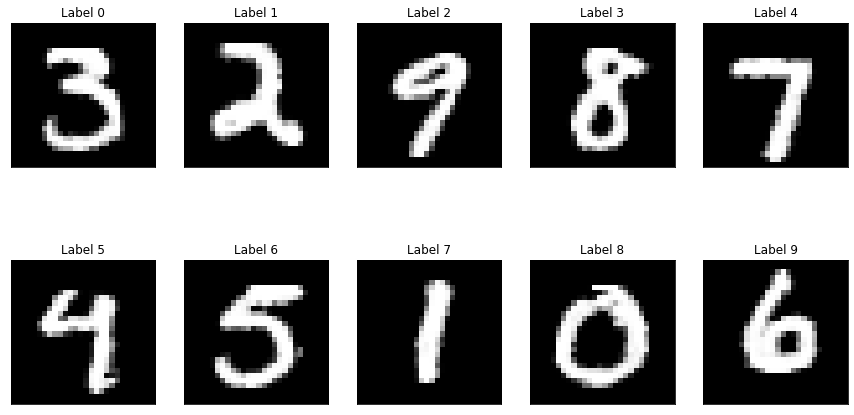

In [37]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 2
columns = 5

for i in range(10) : 
    image_index = i      # image index 
    title = "Label {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index+1) # subplot 
    plt.title(title)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(x[i], cmap=plt.get_cmap('gray'))  
plt.show()


- label 0 : 3
- label 1 : 2
- label 2 : 9
- label 3 : 8
- label 4 : 7
- label 5 : 4
- label 6 : 5
- label 7 : 1
- label 8 : 0
- label 9 : 6

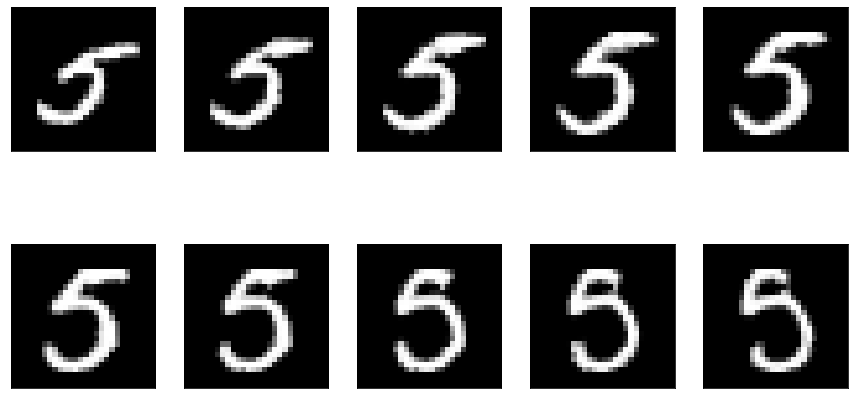

In [41]:
cat_code=[6]*10
cat_code = tf.one_hot(cat_code, depth=10)

conti_code = np.array([[-0.9, 0.1],
                      [-0.7, 0.1],
                      [-0.5, 0.1],
                      [-0.3, 0.1],
                      [-0.1, 0.1],
                      [0.1, 0.1],
                      [0.3, 0.1],
                      [0.5, 0.1],
                      [0.7, 0.1],
                      [0.9, 0.1]])

g_input = Concatenate()([cat_code, conti_code, noise])

x = g_model(g_input)

plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 2
columns = 5

for i in range(10) : 
    image_index = i      # image index 
#     title = "Label {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index+1) # subplot 
#     plt.title(title)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(x[i], cmap=plt.get_cmap('gray'))  
plt.show()




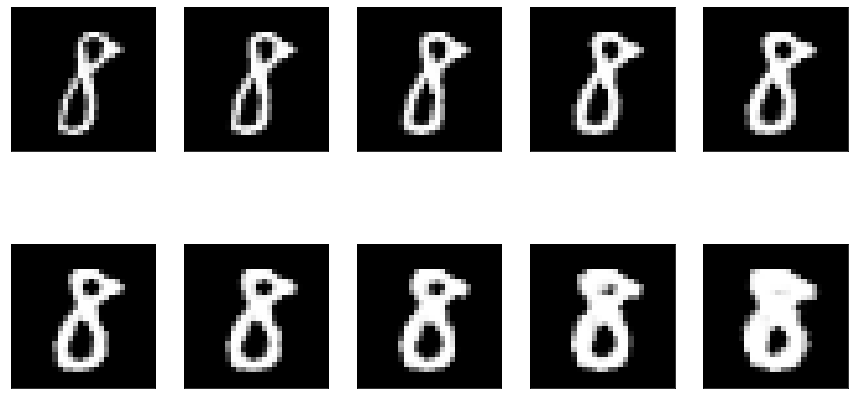

In [42]:
cat_code=[3]*10
cat_code = tf.one_hot(cat_code, depth=10)

conti_code = np.array([[0.1, -0.9],
                      [0.1, -0.7],
                      [0.1, -0.5],
                      [0.1, -0.3],
                      [0.1, -0.1],
                      [0.1, 0.1],
                      [0.1, 0.3],
                      [0.1, 0.5],
                      [0.1, 0.7],
                      [0.1, 0.9]])

g_input = Concatenate()([cat_code, conti_code, noise])

x = g_model(g_input)

plt.rcParams['figure.figsize'] = (15.0, 8.0)

rows = 2
columns = 5

for i in range(10) : 
    image_index = i      # image index 
#     title = "Label {}".format(image_index) # image title
    plt.subplot(rows, columns, image_index+1) # subplot 
#     plt.title(title)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.imshow(x[i], cmap=plt.get_cmap('gray'))  
plt.show()
